In [24]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

#### Read in states, keeping them seperate.

In [25]:
tx_sent = pd.read_hdf('./data/processed/tx_sentiment_mean.hdf', key='df')
ca_sent = pd.read_hdf('./data/processed/ca_sentiment_mean.hdf', key='df')
ny_sent = pd.read_hdf('./data/processed/ny_sentiment_mean.hdf', key='df')
fl_sent = pd.read_hdf('./data/processed/fl_sentiment_mean.hdf', key='df')
ga_sent = pd.read_hdf('./data/processed/ga_sentiment_mean.hdf', key='df')

#### Read in the U.S.A. COVID-19 data.

In [26]:
covid = pd.read_csv('./Covid_Data/time_series_covid19_confirmed_US.csv')

`.grouby()` `Province_State`

In [27]:
covidg = covid.groupby('Province_State').sum()

`.drop()` unnecessary columns.

In [28]:
covidg = covidg.drop(['UID', 'code3', 'FIPS', 'Lat', 'Long_'], axis = 1)

Extract our selected states (states with atleast 1000 tweets or close).

In [29]:
tx_covid = covidg.loc['Texas',:]
ca_covid = covidg.loc['California',:]
ny_covid = covidg.loc['New York',:]
fl_covid = covidg.loc['Florida',:]
ga_covid = covidg.loc['Georgia',:]

`.to_datetime` the index.

In [30]:
tx_covid = pd.DataFrame(tx_covid)
tx_covid.index= pd.to_datetime(tx_covid.index)
ca_covid = pd.DataFrame(ca_covid)
ca_covid.index= pd.to_datetime(ca_covid.index)
ny_covid = pd.DataFrame(ny_covid)
ny_covid.index= pd.to_datetime(ny_covid.index)
fl_covid = pd.DataFrame(fl_covid)
fl_covid.index= pd.to_datetime(fl_covid.index)
ga_covid = pd.DataFrame(ga_covid)
ga_covid.index= pd.to_datetime(ga_covid.index)

Right join our covid data and sentiment data.

In [31]:
tx = tx_covid.join(tx_sent, how = 'right')
ca = ca_covid.join(ca_sent, how = 'right')
ny = ny_covid.join(ny_sent, how = 'right')
fl = fl_covid.join(fl_sent, how = 'right')
ga = ga_covid.join(ga_sent, how = 'right')

Set our shift and rolling average values, then shift and get rolling average of the 2nd difference, and then `.dropna()`.

In [32]:
shift = 1
roll = 1
# NY Best shift 7 roll 3
# FL Best shift 1 roll 1
# GA best shift 1 roll 5 or shift 10 roll 1, shift 11 roll 5
# best OAL shift 9 roll 1, shift 11 roll 5

In [33]:
tx['delta'] = tx['Texas']-tx['Texas'].shift(shift).rolling(roll).mean()
ca['delta'] = ca['California']-ca['California'].shift(shift).rolling(roll).mean()
ny['delta'] = ny['New York']-ny['New York'].shift(shift).rolling(roll).mean()
fl['delta'] = fl['Florida']-fl['Florida'].shift(shift).rolling(roll).mean()
ga['delta'] = ga['Georgia']-ga['Georgia'].shift(shift).rolling(roll).mean()
tx['delta_delta'] = tx['delta']-tx['delta'].shift(1)
ca['delta_delta'] = ca['delta']-ca['delta'].shift(1)
ny['delta_delta'] = ny['delta']-ny['delta'].shift(1)
fl['delta_delta'] = fl['delta']-fl['delta'].shift(1)
ga['delta_delta'] = ga['delta']-ga['delta'].shift(1)
tx['binary_delta'] =np.sign(tx['delta_delta'])
ca['binary_delta'] =np.sign(ca['delta_delta'])
ny['binary_delta'] =np.sign(ny['delta_delta'])
fl['binary_delta'] =np.sign(fl['delta_delta'])
ga['binary_delta'] =np.sign(ga['delta_delta'])

In [34]:
tx.dropna(inplace=True)
ca.dropna(inplace=True)
ny.dropna(inplace=True)
fl.dropna(inplace=True)
ga.dropna(inplace=True)

`.train_test_split()`, making sure shuffle is set to `False`.

In [35]:
features = ['TB_polarity', 'TB_subjectivity']
X_tx = tx[features]
y_tx= tx['binary_delta']
X_tx_train, X_tx_test, y_tx_train, y_tx_test = train_test_split(X_tx, y_tx, random_state=42, shuffle = False)
X_ca = ca[features]
y_ca= ca['binary_delta']
X_ca_train, X_ca_test, y_ca_train, y_ca_test = train_test_split(X_ca, y_ca, random_state=42, shuffle = False)
X_ny = ny[features]
y_ny= ny['binary_delta']
X_ny_train, X_ny_test, y_ny_train, y_ny_test = train_test_split(X_ny, y_ny, random_state=42, shuffle = False)
X_fl = fl[features]
y_fl= fl['binary_delta']
X_fl_train, X_fl_test, y_fl_train, y_fl_test = train_test_split(X_fl, y_fl, random_state=42, shuffle = False)
X_ga = ga[features]
y_ga= ga['binary_delta']
X_ga_train, X_ga_test, y_ga_train, y_ga_test = train_test_split(X_ga, y_ga, random_state=42, shuffle = False)

Instantiate, fit, and score our models.

In [36]:
tx_model = LogisticRegression().fit(X_tx_train, y_tx_train)
ca_model = LogisticRegression().fit(X_ca_train, y_ca_train)
ny_model = LogisticRegression().fit(X_ny_train, y_ny_train)
fl_model = LogisticRegression().fit(X_fl_train, y_fl_train)
ga_model = LogisticRegression().fit(X_ga_train, y_ga_train)

In [37]:
scores = []
scores.append(tx_model.score(X_tx_test, y_tx_test))
scores.append(ca_model.score(X_ca_test, y_ca_test))
scores.append(ny_model.score(X_ny_test, y_ny_test))
scores.append(fl_model.score(X_fl_test, y_fl_test))
scores.append(ga_model.score(X_ga_test, y_ga_test))
print(scores)

[0.47058823529411764, 0.37142857142857144, 0.5142857142857142, 0.6470588235294118, 0.5]


Check the Florida model's confusion matrix.

{'-1.0': {'precision': 0.6666666666666666,
  'recall': 0.5882352941176471,
  'f1-score': 0.625,
  'support': 17},
 '1.0': {'precision': 0.631578947368421,
  'recall': 0.7058823529411765,
  'f1-score': 0.6666666666666667,
  'support': 17},
 'accuracy': 0.6470588235294118,
 'macro avg': {'precision': 0.6491228070175439,
  'recall': 0.6470588235294118,
  'f1-score': 0.6458333333333334,
  'support': 34},
 'weighted avg': {'precision': 0.6491228070175438,
  'recall': 0.6470588235294118,
  'f1-score': 0.6458333333333334,
  'support': 34}}

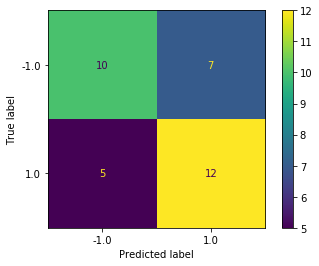

In [38]:
log_pred = fl_model.predict(X_fl_test)
plot_confusion_matrix(fl_model,X_fl_test,y_fl_test);
classification_report(y_fl_test,log_pred, output_dict=True)

/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'-1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18},
 '1.0': {'precision': 0.47058823529411764,
  'recall': 1.0,
  'f1-score': 0.6399999999999999,
  'support': 16},
 'accuracy': 0.47058823529411764,
 'macro avg': {'precision': 0.23529411764705882,
  'recall': 0.5,
  'f1-score': 0.31999999999999995,
  'support': 34},
 'weighted avg': {'precision': 0.22145328719723184,
  'recall': 0.47058823529411764,
  'f1-score': 0.30117647058823527,
  'support': 34}}

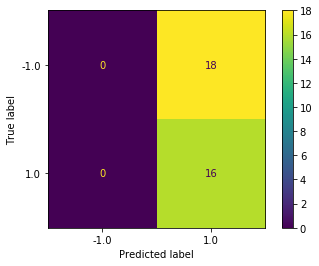

In [39]:
log_pred = tx_model.predict(X_tx_test)
plot_confusion_matrix(tx_model,X_tx_test,y_tx_test);
classification_report(y_tx_test,log_pred, output_dict=True)

/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'-1.0': {'precision': 0.5142857142857142,
  'recall': 1.0,
  'f1-score': 0.6792452830188679,
  'support': 18},
 '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 17},
 'accuracy': 0.5142857142857142,
 'macro avg': {'precision': 0.2571428571428571,
  'recall': 0.5,
  'f1-score': 0.33962264150943394,
  'support': 35},
 'weighted avg': {'precision': 0.2644897959183673,
  'recall': 0.5142857142857142,
  'f1-score': 0.34932614555256064,
  'support': 35}}

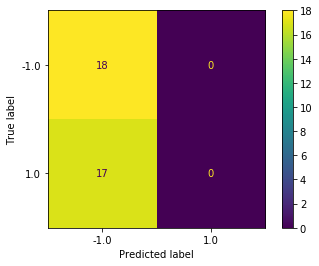

In [40]:
log_pred = ny_model.predict(X_ny_test)
plot_confusion_matrix(ny_model,X_ny_test,y_ny_test);
classification_report(y_ny_test,log_pred, output_dict=True)

{'-1.0': {'precision': 0.5217391304347826,
  'recall': 0.8,
  'f1-score': 0.6315789473684211,
  'support': 15},
 '1.0': {'precision': 0.4,
  'recall': 0.15384615384615385,
  'f1-score': 0.2222222222222222,
  'support': 13},
 'accuracy': 0.5,
 'macro avg': {'precision': 0.4608695652173913,
  'recall': 0.47692307692307695,
  'f1-score': 0.42690058479532167,
  'support': 28},
 'weighted avg': {'precision': 0.46521739130434786,
  'recall': 0.5,
  'f1-score': 0.44152046783625737,
  'support': 28}}

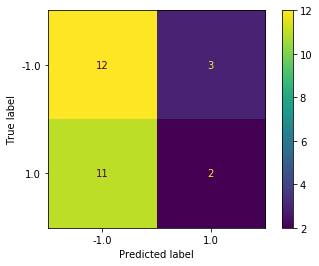

In [41]:
log_pred = ga_model.predict(X_ga_test)
plot_confusion_matrix(ga_model,X_ga_test,y_ga_test);
classification_report(y_ga_test,log_pred, output_dict=True)

/Library/Python/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'-1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22},
 '1.0': {'precision': 0.37142857142857144,
  'recall': 1.0,
  'f1-score': 0.5416666666666666,
  'support': 13},
 'accuracy': 0.37142857142857144,
 'macro avg': {'precision': 0.18571428571428572,
  'recall': 0.5,
  'f1-score': 0.2708333333333333,
  'support': 35},
 'weighted avg': {'precision': 0.1379591836734694,
  'recall': 0.37142857142857144,
  'f1-score': 0.20119047619047617,
  'support': 35}}

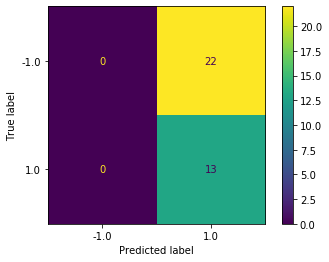

In [42]:
log_pred = ca_model.predict(X_ca_test)
plot_confusion_matrix(ca_model,X_ca_test,y_ca_test);
classification_report(y_ca_test,log_pred, output_dict=True)

So aside from Florida, with these parameters the models seem to just pick one or the other.

Plot our polarity and subjectivity plots.

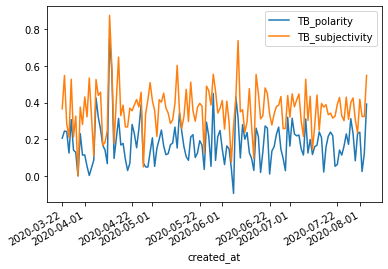

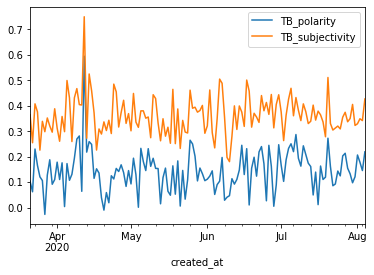

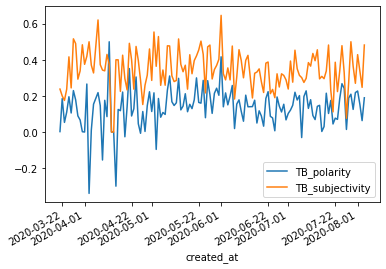

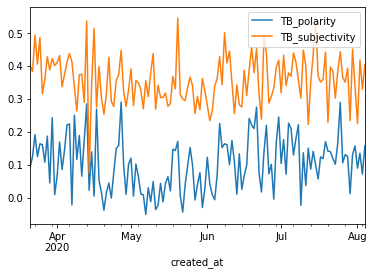

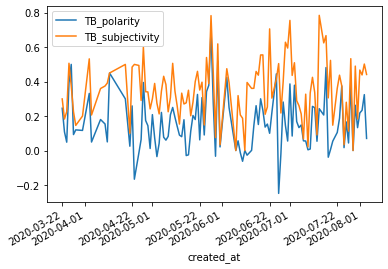

In [43]:
fl.plot( y = ['TB_polarity', 'TB_subjectivity'])
ca.plot( y = ['TB_polarity', 'TB_subjectivity'])
tx.plot( y = ['TB_polarity', 'TB_subjectivity'])
ny.plot( y = ['TB_polarity', 'TB_subjectivity'])
ga.plot( y = ['TB_polarity', 'TB_subjectivity']);

# Project_5_Team
## COVID-19 Rates via Sentiment Analysis of Tweets
#### Lucas Dwyer, Henry Valk, and Margret Rubio-Keefer

## Problem Statement:
##### The COVID-19 response has been largely regional and state-based in nature. Some states have enacted strictly enforced stay-at-home policies, while others have provided guidelines. It would be worthwhile to compare the sentiment analysis of social media posts across geographic regions and compare them to  the local  the occurrences of the pandemic in those areas. Furthermore, it would be useful if any time series forecasting model based on social media sentinment analysis data.

## Datasets
##### Selected states (for data size purposes): NY, CA, TX, FL, GA
### [CORONAVIRUS (COVID-19) GEO-TAGGED TWEETS DATASET](https://ieee-dataport.org/open-access/coronavirus-covid-19-geo-tagged-tweets-dataset)
##### [Hydrator](https://github.com/DocNow/hydrator/releases/tag/v0.0.13) must be used to process the tweets.
This dataset was processed down to the daily mean sentinment by TextBlob in the form of polarity `TB_polarity` and subjectivity `TB_subjectivity`, indexed by day, for the five selected states.

### [COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19)
This dataset was processed down to the daily confirmed cases and daily confirmed deaths, indexed by day, for the five selected states.

## Models
### Logistic Regression
#### Performance
We only got a score of 62% accuracy in picking the 2nd difference of the confirmed cases, however, it is important to note that based on the confusion matrix, the model might still be useful.
#### <center>The Florida Next Day Model</center>
![Florida Model's Confusion Matrix alt ><](assets/fl_conf.png)
It is possible that the reason that a next day model, despite the virus having an incubation period of 2-12 days, might perform like this would be that many people might begin tweeting about feeling ill, and then going to get tested, and then they get their results the next day(s). While waiting for the results, they might begin tweeting more about the virus.
<br>
<br>
It is also important to note that the majority of the errors are false positives; the model predicted that the 2nd difference would be positive, when in fact, it was negative. Great! Couldn't be happier to be wrong! However of the 34 day forecasting window, only 3 false negatives, or cases when we predicted the 2nd difference would be negative, and it was positive. That's less than 9% predictions under rating the coming change in the 2nd difference.



